# UCI bank marketing prediction

**Tags**: #logistics regression #K-Means unsupervised model

**Autor**: CHU LIN

**Last updat**e: 2025-12-18(created: 2025-12-10)

**Description**: This notebook provides an predition of whether customers will accept time deposits.

# Input
> Library: import the libraries were used on this project

> Function: make utility functions for maintain and handing similar and frequent problems

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import missingno as msno
import logging
import os
import shap

from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             recall_score,
                             f1_score, roc_curve,
                             roc_auc_score,
                             ConfusionMatrixDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

**Get the dataset from my github**:

"https://raw.githubusercontent.com/SeekkerChu/UCI_Marketing/refs/heads/main/Data_set/bank_additional.csv.text"

**Why I chose this dataset?**


>I can gain a deeper understanding on real-world data: like "unkown" values.

>The dataset provides a rich variety of features, including client demographics, past marketing campaign results, and macro-economic indicators.

In [123]:
URL = "https://raw.githubusercontent.com/SeekkerChu/UCI_Marketing/refs/heads/main/Data_set/bank_additional.csv.text"

**Setting log files:** (LLM helped since it is my first time use log file)

Avoid lengthy scrolling through unnecessary information.

In [124]:
logging.basicConfig(
    filename="analysis_verbose.log",
    level=logging.DEBUG,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

logger = logging.getLogger()

**Three functions** (LLM helps me to fix the output, like when I want to save log or draw the different plots):
> `make_ditribution` for ploting, given a dataframe or list, this function can auto select how many columns and rows in one figure, and save them into log files

> `detect_outliers` for detecting outliers based on IQR method

> `show_images_grids` for showing your images in your file.

In [125]:
def make_distribution(data,
                      cols=5,
                      figsize=(16, 10),
                      title=None,
                      save_dir="/content/sample_data",
                      logger=None,):
    """
    Create a function to make numerical distribution(LLMs help)

    Parameters:
    - data: DataFrame of categorical columns OR list of Series
    - cols: number of subplot columns
    - figsize: figure size
    - title: optional main title
    - save_dir: directory where plots are saved
    - logger: logging.Logger object (if you want to save)
    """

    os.makedirs(save_dir, exist_ok=True)

    if hasattr(data, "columns"):
        data_series = [data[col] for col in data.columns]
        col_names = list(data.columns)
    else:
        data_series = data
        col_names = [
            s.name if hasattr(s, "name") else f"col_{i}"
            for i, s in enumerate(data)
        ]

    n = len(data_series)
    rows = (n + cols - 1) // cols

    saved_files = []

    for i, series in enumerate(data_series):
        plt.figure(figsize=(6,4))
        sns.histplot(series, kde=True)
        plt.title(col_names[i])

        fname = f"{col_names[i]}_dist.png"
        fpath = os.path.join(save_dir, fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight")
        plt.close()

        saved_files.append(fpath)

        if logger:
            logger.info(f"Numeric distribution saved: {fpath}")

    if title:
        if logger:
            logger.info(f"Distribution plotting finished for {len(data_series)} columns: {col_names}")
        return saved_files

    return saved_files

In [126]:
def detect_outliers(df, cols, precent_q1 = 0.25, precent_q3 = 0.75):
  """
  function for detect the outliers

  Parameters:
    - df: DataFrame
    - cols: columns
    - precent_q1: q1, default will be 0.25
    - precent_q3: q3, default will be 0.75
  """
  outlier_info = {}

  if precent_q1 >=1 or precent_q1 <=0:
    raise ValueError("please set q1 0 to 1")
  if precent_q3 >=1 or precent_q3 <=0:
    raise ValueError("please set q3 0 to 1")
  if (precent_q1 + precent_q3) != 1:
    raise ValueError("please set q3 add q1 to 1")

  for col in cols:
      Q1 = df[col].quantile(precent_q1)
      Q3 = df[col].quantile(precent_q3)
      IQR = Q3 - Q1

      lower = Q1 - 1.5 * IQR
      upper = Q3 + 1.5 * IQR

      mask = (df[col] < lower) | (df[col] > upper)
      count = mask.sum()
      percentage = count / len(df) * 100

      outlier_info[col] = {
          "lower": lower,
          "upper": upper,
          "count": count,
          "percentage": round(percentage, 2)
        }

  return pd.DataFrame(outlier_info).T

In [127]:
def show_images_grids(
    img_paths,
    cols=3,
    figsize=(15, 5),
    title=None
):
    """
    Display multiple PNG images in the same figure using subplots.

    Parameters:
    - img_paths (list of str): Paths to image files that you want to show
    - cols (int): Number of columns in the grid
    - figsize(tuple): Figure size
    - title(str): Overall figure title
    """

    if len(img_paths) == 0:
        raise ValueError("img_paths is empty")

    rows = (len(img_paths) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, path in enumerate(img_paths):
        if not os.path.exists(path):
            axes[i].set_visible(False)
            continue

        img = mpimg.imread(path)
        axes[i].imshow(img)

        fname = os.path.basename(path)
        axes[i].set_title(fname.replace("_dist.png", ""))

        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    if title:
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()

# Data Cleaning:

> Read csv file separate by ";", Copy row data into df_clean, make sure row data haven't changed

> Describe numerical statistics values by `.describe()`

> Find out NA values, but the dataset not includes the NA but "unknown" values. For different percentage contents, choose impute, remove or keep.

> Detect outliers for each numerical columns, and based on finance concepts to decide remove the outliers or impute.


In [128]:
df = pd.read_csv(URL, sep=";")
df_clean = df.copy()

Total features:

In [129]:
logger.info("loading data")

logger.debug(f".head() output：\n{df.head()}")

Look at the describe, thinking the min and max values whether are reasonable.

In [130]:
describe_df = df.describe()

logger.debug(f"Describe: /n{describe_df}")
describe_df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Look at how many unknown values in the dataset

In [131]:
unknown_per_column = df.eq("unknown").sum()
logger.debug(f"Total Unknown values: \n{unknown_per_column}")

unknown_cols = unknown_per_column[unknown_per_column > 0]
logger.debug(f"Columns with unknowns: \n{unknown_cols}")
unknown_cols

,0
job,39
marital,11
education,167
default,803
housing,105
loan,105


Since 'job','marital','education','housing','loan','contact','month','day_of_week','poutcome' features only showed 11/4119(0.26%) to 167/4119(4.05%), so I decided to impute the most common data to replace the "unknown" values.

In [132]:
categorical_cols = ['job','marital','education','housing','loan','contact','month','day_of_week','poutcome']
df_clean[categorical_cols] = df_clean[categorical_cols].replace('unknown', np.nan)

Use Msno matrix and bar plots show their "unknown" values

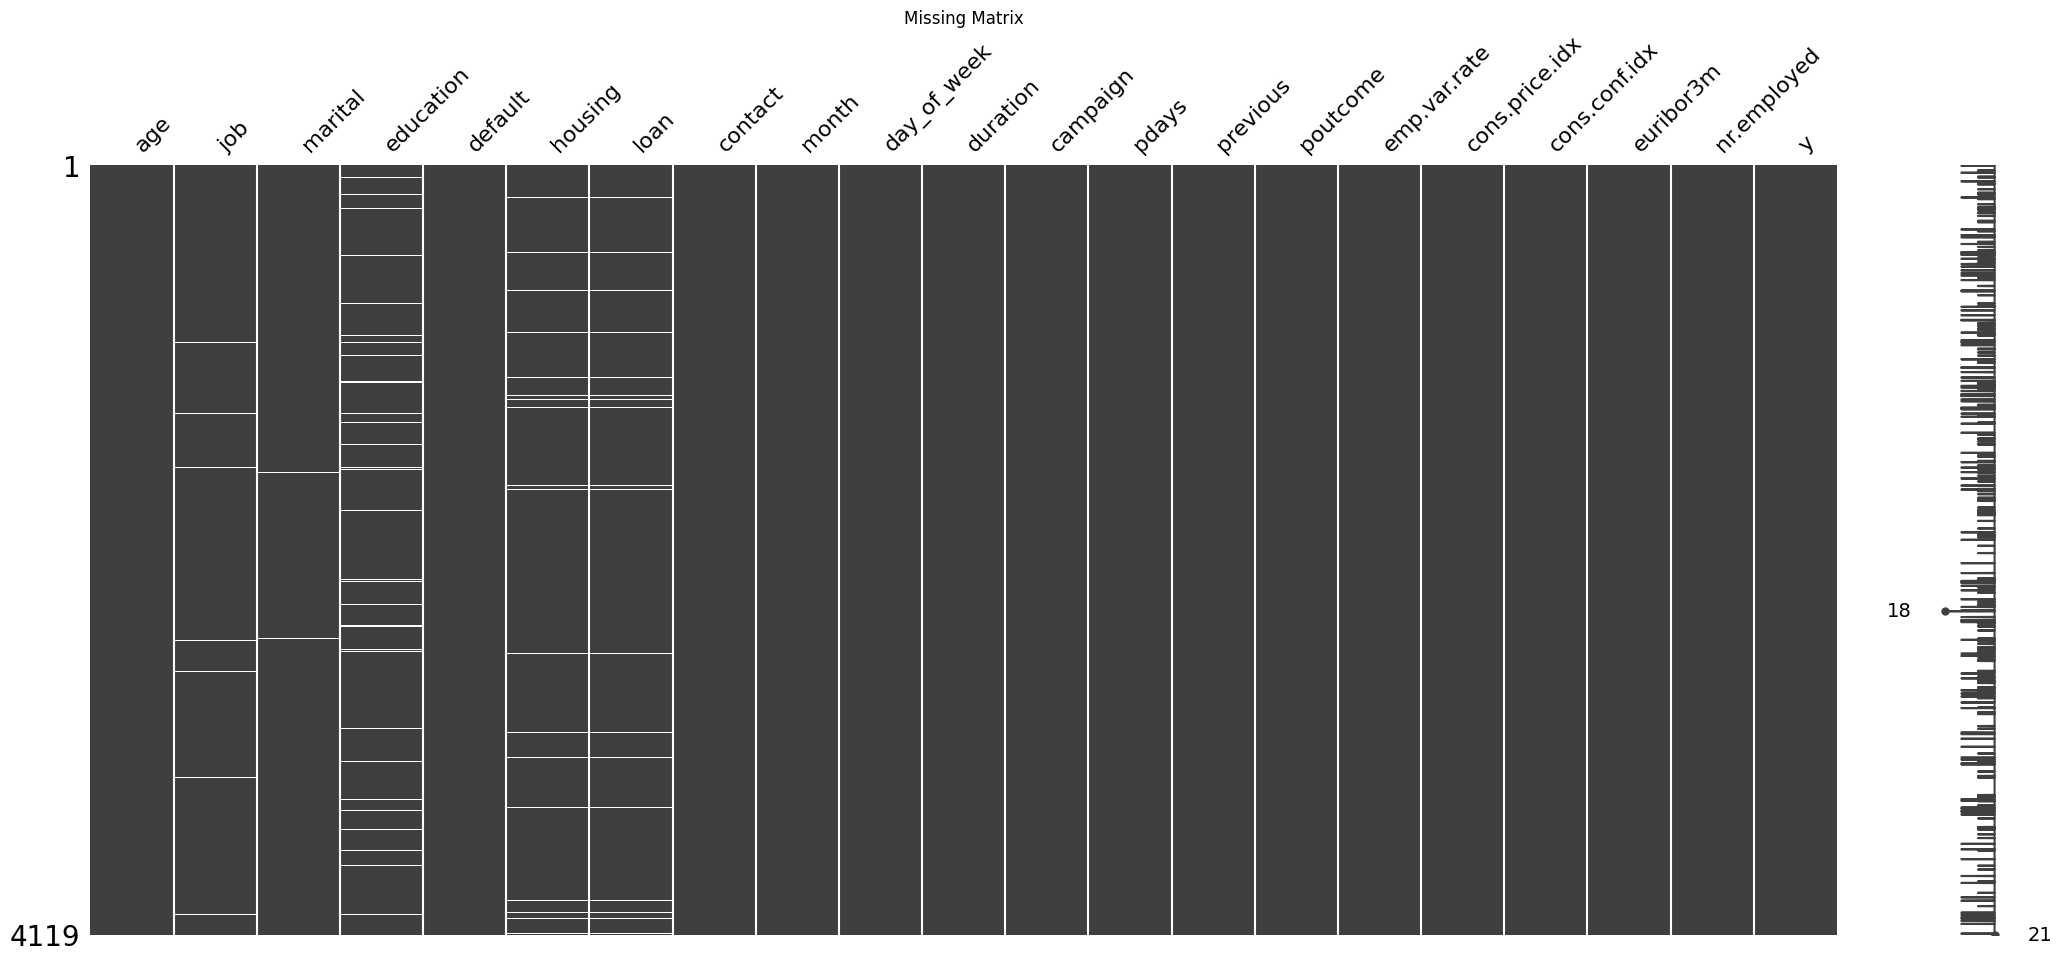

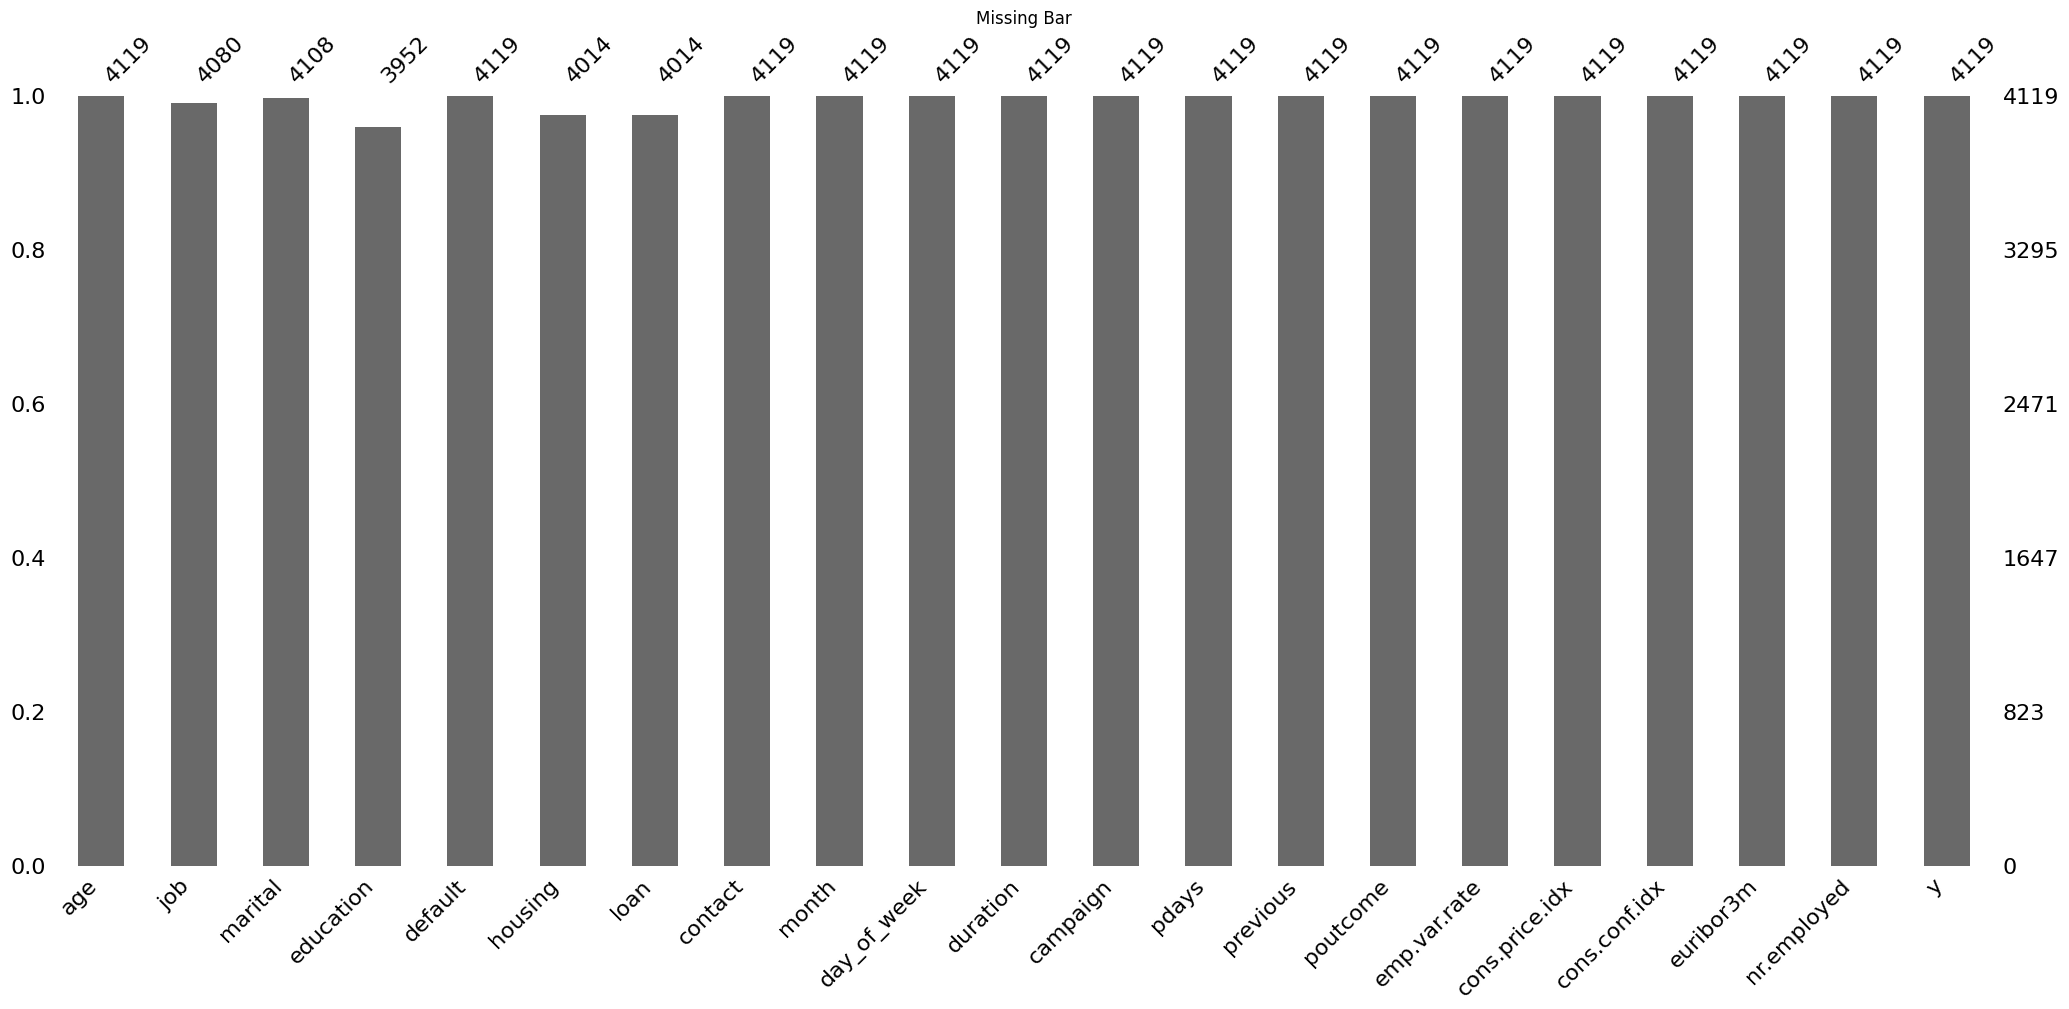

In [133]:
msno.matrix(df_clean)
plt.title("Missing Matrix")
plt.show()

msno.bar(df_clean)
plt.title("Missing Bar")
plt.show()

which shows unknown did not change a lot, thus impute a most common value to replace the "unknown" values will be an better idea

In [134]:
cols_small_missing = ["job", "marital", "housing", "education", "loan"]
for col in cols_small_missing:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])


df_clean["y"] = df_clean["y"].map({"yes": 1, "no": 0})
mapped_counts = df_clean["y"].value_counts()
logger.info(f"'y' projected:\n{mapped_counts}")

Split the numerical columns and categorical columns.

In [135]:
numeric_cols = [
    'age', 'duration', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]

categorical_cols = ['job','marital','education','default','housing','loan',
                    'contact','month','day_of_week','poutcome']

Detect outliers by IQR method, and select the main features to show.

In [136]:
outliers_table = detect_outliers(df_clean, numeric_cols,precent_q1=0.05, precent_q3=0.95)

logger.debug(f"Outliers percentage: \n{outliers_table}")
outliers_table.loc[['campaign','pdays','previous']]

,lower,upper,count,percentage
campaign,-8.0,16.0,26.0,0.63
pdays,999.0,999.0,160.0,3.88
previous,-1.5,2.5,43.0,1.04


Here shows campaign and previous's lowers are negative, but in real data, they don't have negative values, so all outliers are greater than their uppers.

It also shows weird pdays's upper and lower. they are all 999. We have to make a distribution plot to validate.

**Result**: Don't remove the outliers, since they are real data and can be used on preidctions.

# EDA

**Make a pair plot** to see which features can be used on our models.

**Make a distribution plot of numerical data** to see their density.


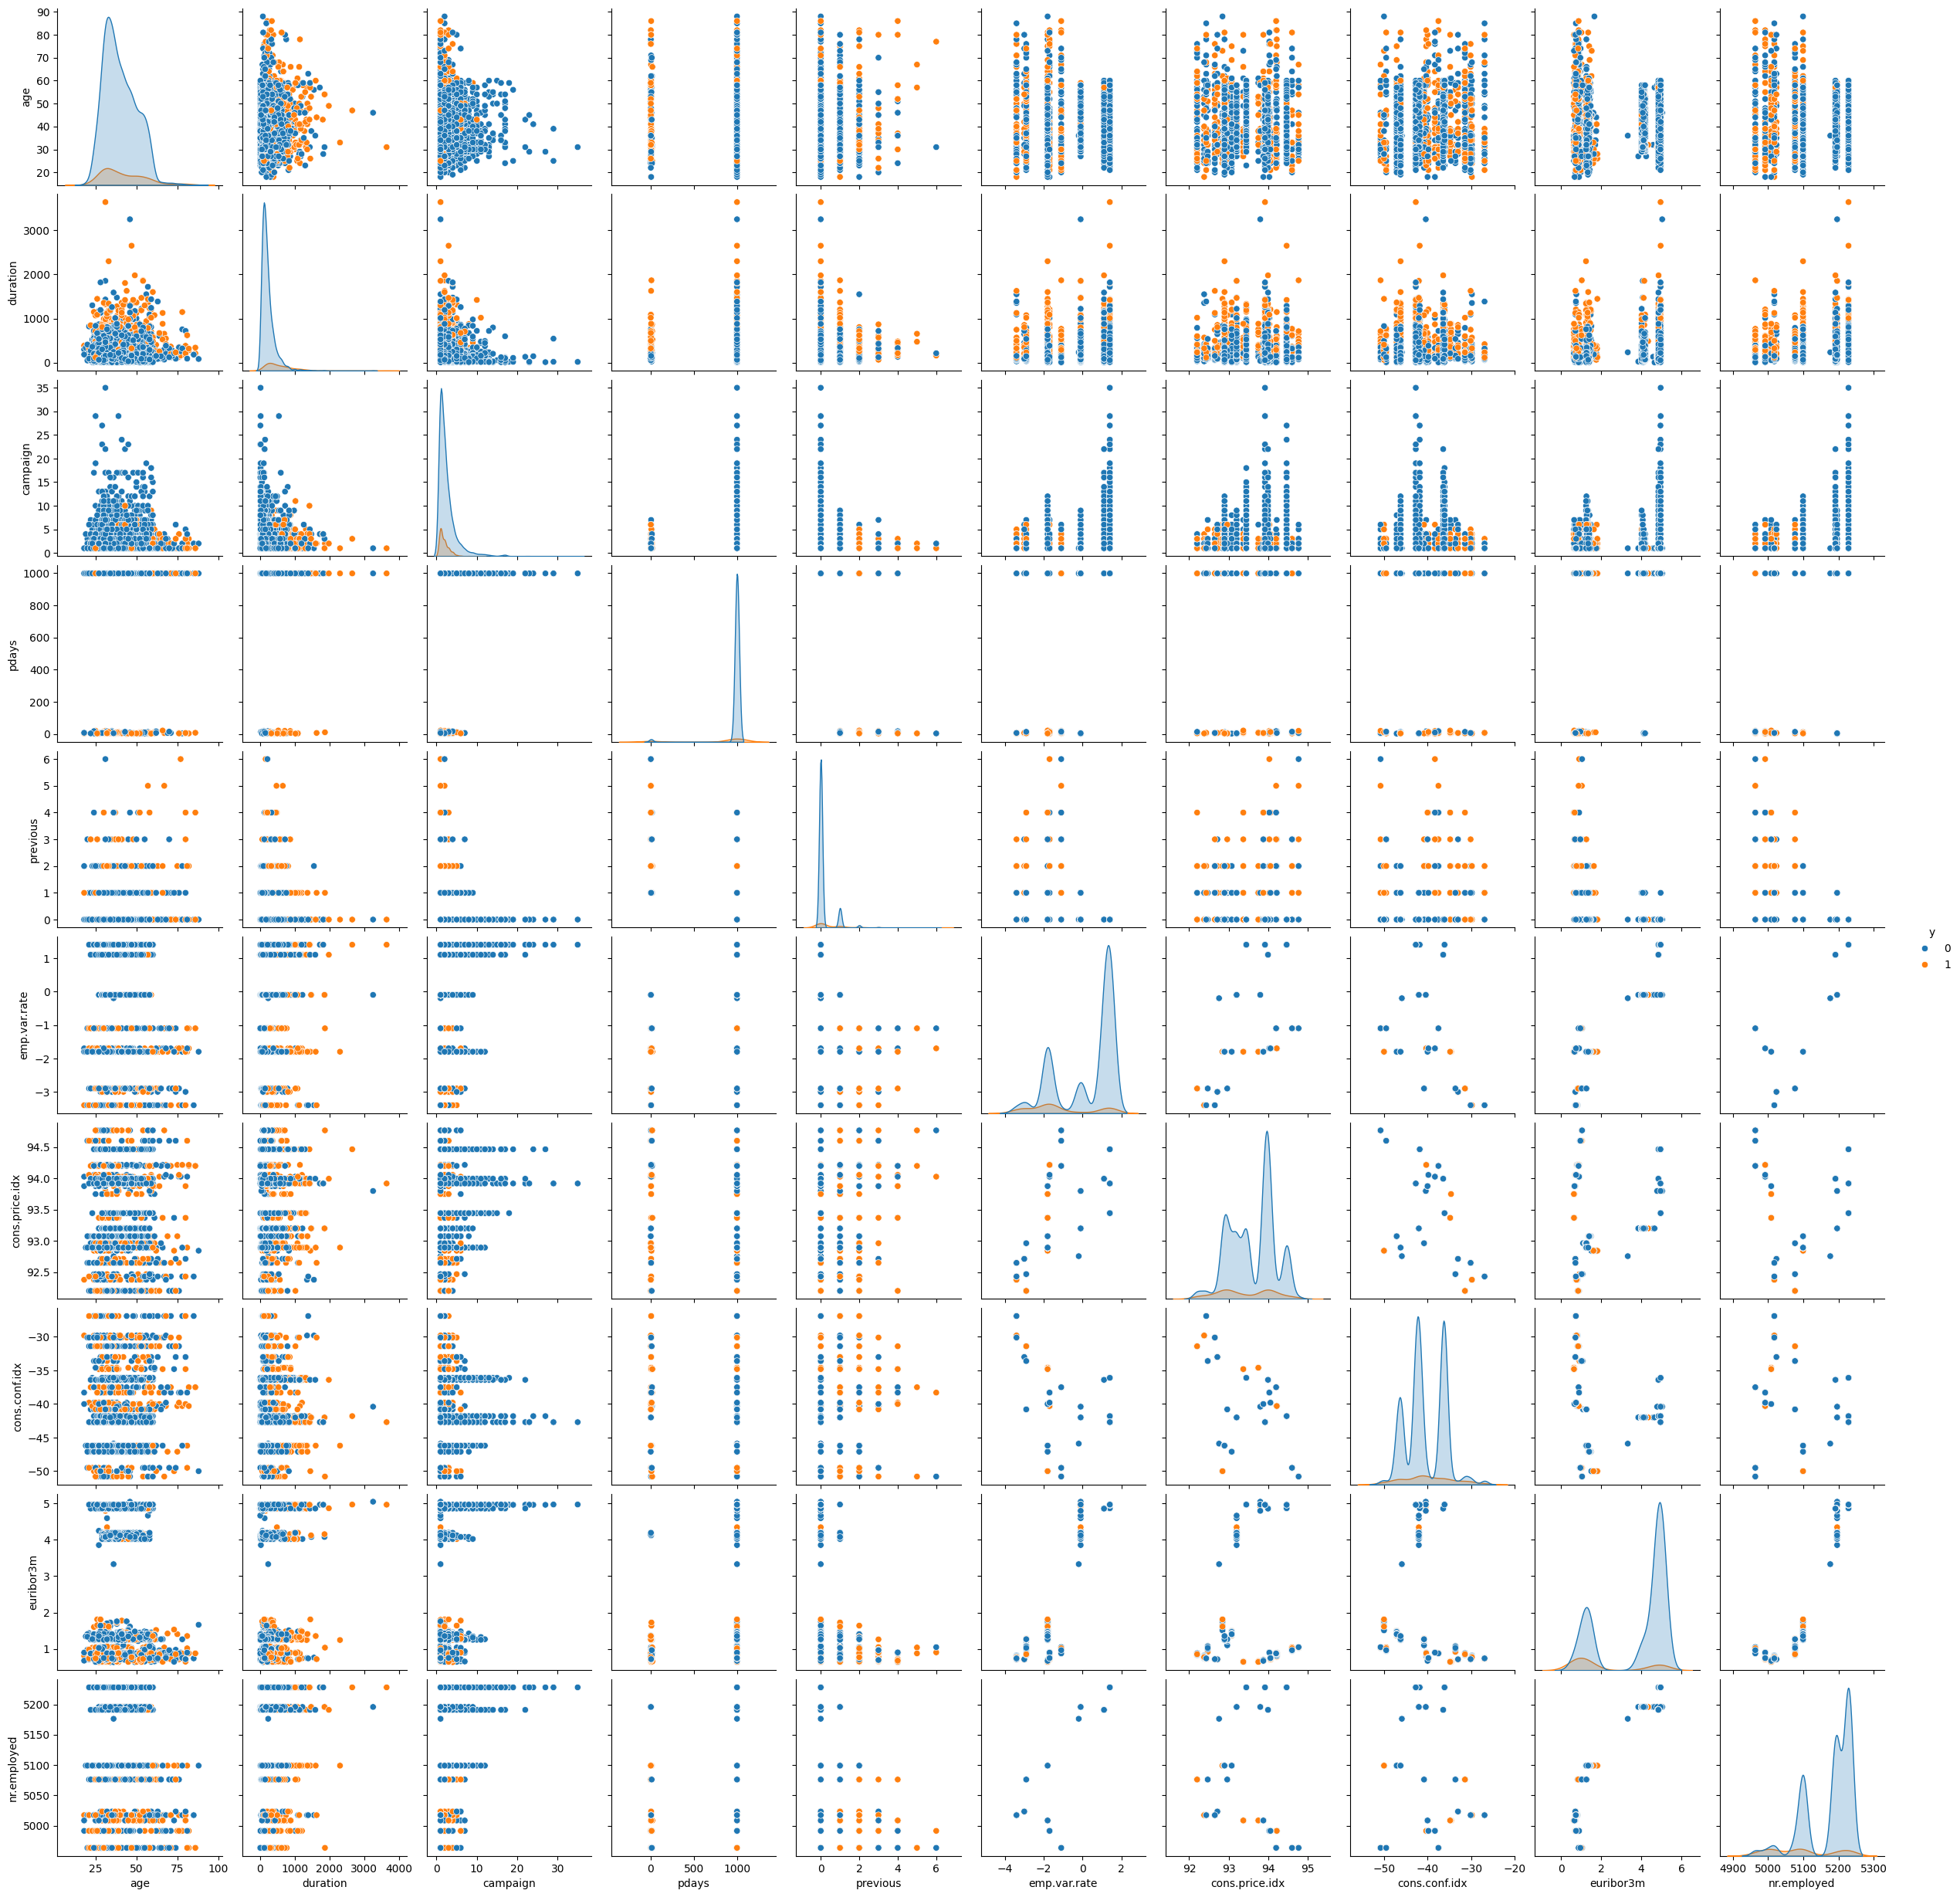

In [137]:
sns.pairplot(df_clean, hue='y')

I think we don't have to put durtion into the model, since it is future informations, and the pariplot shows they have a strong relationship, if put it into the model, the model may base on this feature to predict the value.

Save all distribution images into log file.

In [138]:
files = make_distribution(
    df_clean[numeric_cols],
    cols=5,
    figsize=(18,10),
    title="Numeric Distributions",
    logger=logger
)

logger.info(f"All numeric distribution files: {files}")

Show the key features's distribution:

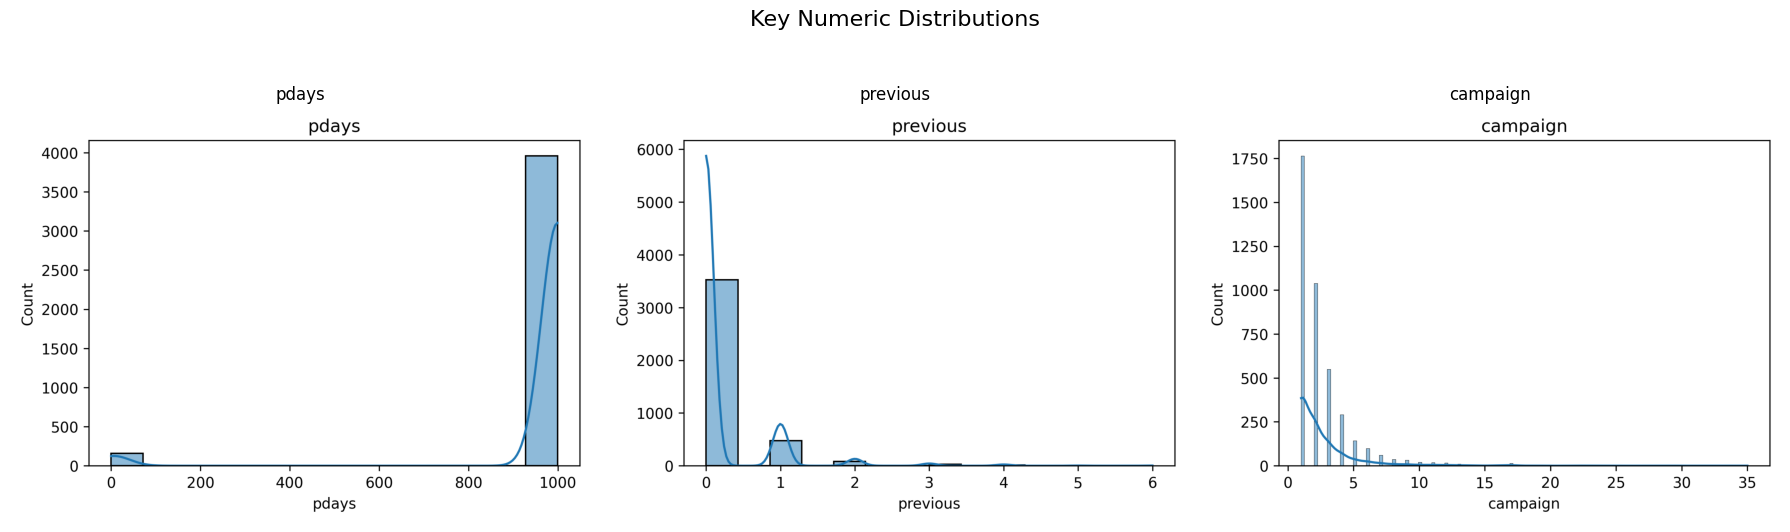

In [139]:
img_paths = [
    "/content/sample_data/pdays_dist.png",
    "/content/sample_data/previous_dist.png",
    "/content/sample_data/campaign_dist.png"
]

show_images_grids(
    img_paths,
    cols=3,
    figsize=(18,6),
    title="Key Numeric Distributions"
)

After the plots, we know that pdays only has 0 and 999, but other two have mutiple number, so we will keep previous and campaign's row data. Since they mean the real data.

For pdays, I think it is better to change it into binary data like 0 or 1, since it only has two values.

In [140]:
df_clean['pdays'] = np.where(df_clean['pdays'] == 999, 1, 0)

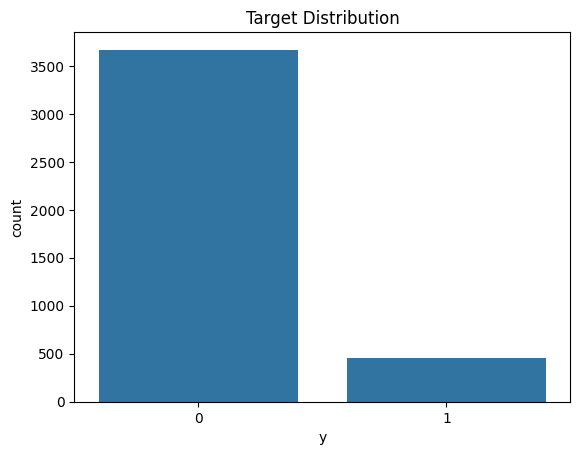

In [141]:
sns.countplot(data=df_clean, x='y')
plt.title("Target Distribution")
plt.show()

And target value shows imbalance data, it has a lot of 0 (87.5%), which may affect our train and test split part. Eventually will affect the recall and other metrics

# Modeling in logistics and K-Means

**Logistics Regression:**

Build a preprocessor for changing
>Handle categoricla variables(Encoding)

>Normalize and Standarlize numerical

Pipeline for maintaining

Since y has 87.5% no and 12.5% yes:
>control the weight on model setting

>Change threshold.

Split X and Y, train and test in 8:2

In [142]:
X = df_clean.drop(['y','duration'], axis=1)
Y = df_clean['y']

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

Setting numeric and categorical columns

In [144]:
numeric_cols = [
    'age', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]

categorical_cols = [
    'job','marital','education','default','housing','loan',
                    'contact','month','day_of_week','poutcome'
]

Preprocessor for logisticRegression:

> use transformer to normalize numerical values, encode categorical values

> use Pipeline to maintain the process, first will be preprocess, last will be model building

Fit the model in the end.

In [145]:
preprocessor = ColumnTransformer(
    transformers=[
        ('category', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('numerical', StandardScaler(), numeric_cols)
    ]
)

model_log = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

model_log.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('category',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome']),
                                                 ('numerical', StandardScaler(),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

SHAP explainor:

Save coef of each features into log file, and shows top 3 coefficients on the model.

Validate the model by accuracy and confusion matrix

In [146]:
y_pred = model_log.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
cm = confusion_matrix(y_pred, y_test)

print(f"Accuracy: {accuracy}")
print(f"confusion matrix:")
print(cm)

Accuracy: 0.8288834951456311
confusion matrix:
[[631  38]
 [103  52]]


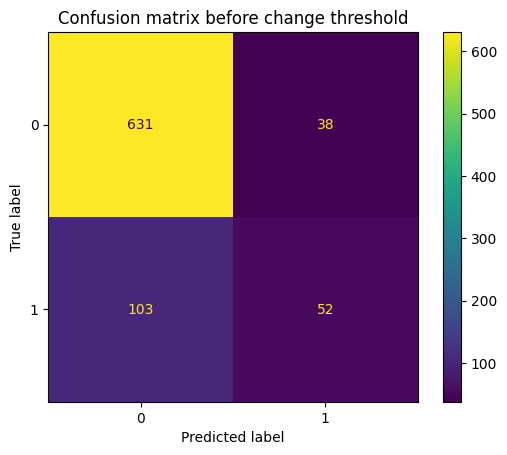

In [147]:
cm_plot = ConfusionMatrixDisplay(cm,display_labels=[0,1])
cm_plot.plot()
plt.title("Confusion matrix before change threshold")
plt.show()

Seems like the TP is low, so its recall is low. Even through accuracy shows good, but the main goal is to predict whether clients will accept fixed deposits, so recall should be high

In [148]:
y_test_proba = model_log.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_proba)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.7906600060551013


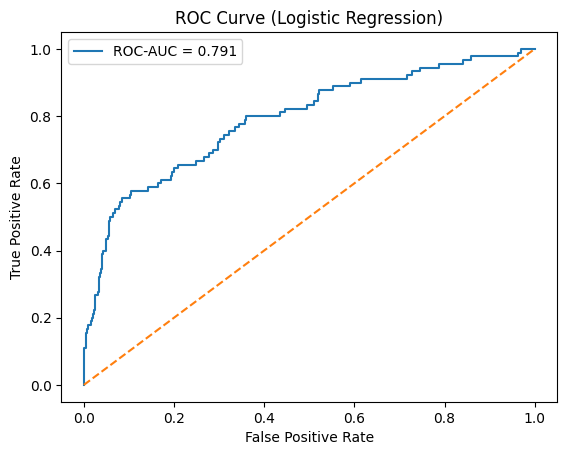

In [149]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.show()

The model demonstrates solid discriminative ability with a ROC-AUC of 0.791. This indicates a high probability that the model will rank a random positive instance higher than a random negative one.

After the plot, maybe change the threshold can make a better result. Based on each loop.
> use F1-score to select the appropriate threshold. Since F1-Score can balance recall and precision rates.

In [150]:
y_val_proba = model_log.predict_proba(X_test)[:,1]
thresholds = np.arange(0.0, 1.01, 0.01)

threshold = 0
f1 = 0
best_f1 = 0

for t in thresholds:
    y_val_pred = (y_val_proba >= t).astype(int)
    f1 = f1_score(y_test, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        threshold = t

print("Threshold based on F1-score: (max F1):", threshold)

Threshold based on F1-score: (max F1): 0.66


Use new threshold into model

In [151]:
y_test_proba = model_log.predict_proba(X_test)[:,1]
y_test_pred = (y_test_proba >= threshold).astype(int)

cm_optimize = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm_optimize)
print("Recall:", recall_score(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Confusion Matrix:
 [[689  45]
 [ 45  45]]
Recall: 0.5
Accuracy: 0.8907766990291263


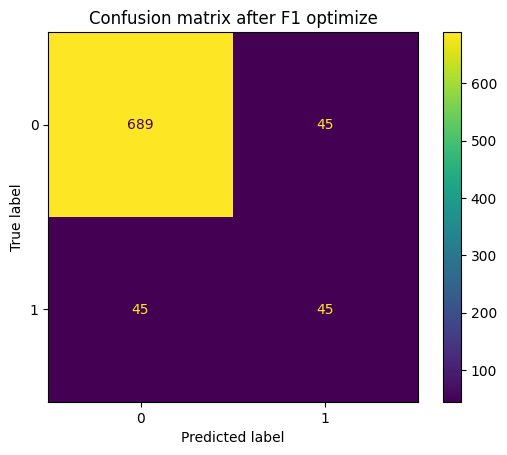

In [152]:
cm_optimize_plot = ConfusionMatrixDisplay(cm_optimize)

cm_optimize_plot.plot()
plt.title("Confusion matrix after F1 optimize")
plt.show()

Here shows the recall equals to 0.5 by changing threshold, and the accuracy also higher than before.

***K-Means***
> Use the preprocessor that we already had

In [153]:
X_prepared = preprocessor.fit_transform(X)

elbow method to select the k

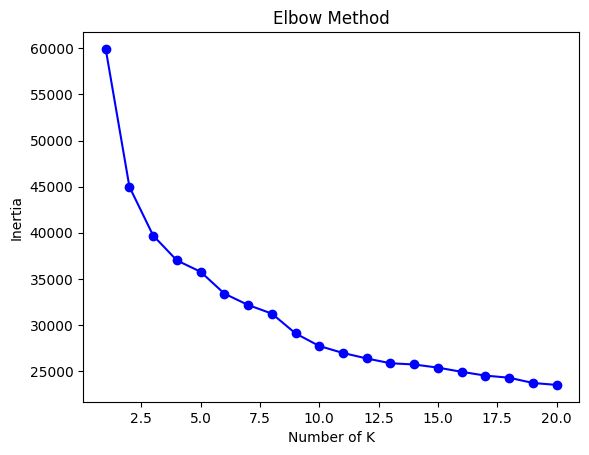

In [154]:
inertia = []
K = range(1, 21)
for k in K:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X_prepared)
  inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

According to the elbow plot, the Inertia is droping rapidly, and after 4 it is tending towards stability. Thus, I selected `k = 3`

In [155]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_prepared)

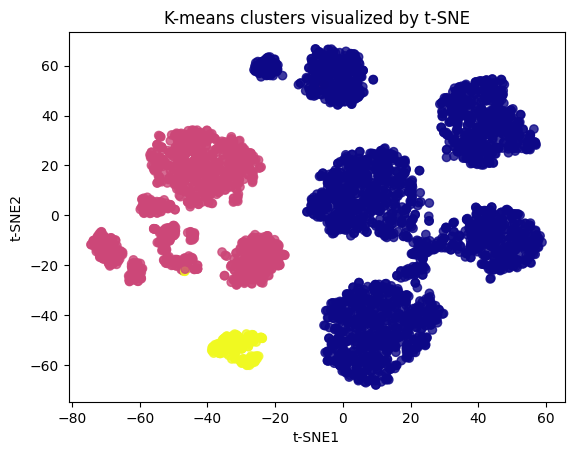

In [156]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_prepared)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters, cmap='plasma', alpha=0.8)
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.title('K-means clusters visualized by t-SNE')
plt.show()

From the t-SNE plot, although I selected `k = 3`, there are still a lot of small islands

**Coefficent analysis and SHAP interpreter**:

In [157]:
# Get the preprocessing step
preprocess = model_log.named_steps['preprocess']

# LLM helped me to fix how to select category and numerical values
feature_names = []

for name, transformer, cols in preprocess.transformers_:
    if name == 'category':
        # OneHotEncoder
        ohe = transformer
        ohe_feature_names = list(ohe.get_feature_names_out(cols))
        feature_names.extend(ohe_feature_names)
    elif name == 'numerical':
        # Numerical features keep their original names
        feature_names.extend(cols)

log_reg = model_log.named_steps['clf']

coefficients = log_reg.coef_[0]
intercept = log_reg.intercept_[0]


coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False)

logger.debug(f"here is coef of all features: \n{coef_df}")

top3_positive = coef_df.head(3)
top3_negative = coef_df.tail(3)

coef_top3 = pd.concat([top3_positive, top3_negative])
logger.debug(f"Top 3 features influencing the model: \n{coef_top3}")
coef_top3

,feature,coefficient
35,month_mar,1.283004
32,month_dec,0.584793
53,cons.price.idx,0.582769
6,job_self-employed,-0.615339
37,month_nov,-0.701548
52,emp.var.rate,-1.268786


The table shows when during Mar ot Dec will enhance the chances of success. However, when during Nov, it shows negative inhibitory effect.


> Explain this business is seasonal

> That is why T-SNE has some subclusters, they might decided by different months

> That is why `k = 3`, since it depends on months and self-employed


Make PCA plots by `k = 3` to compare true target 1 in different clusters.




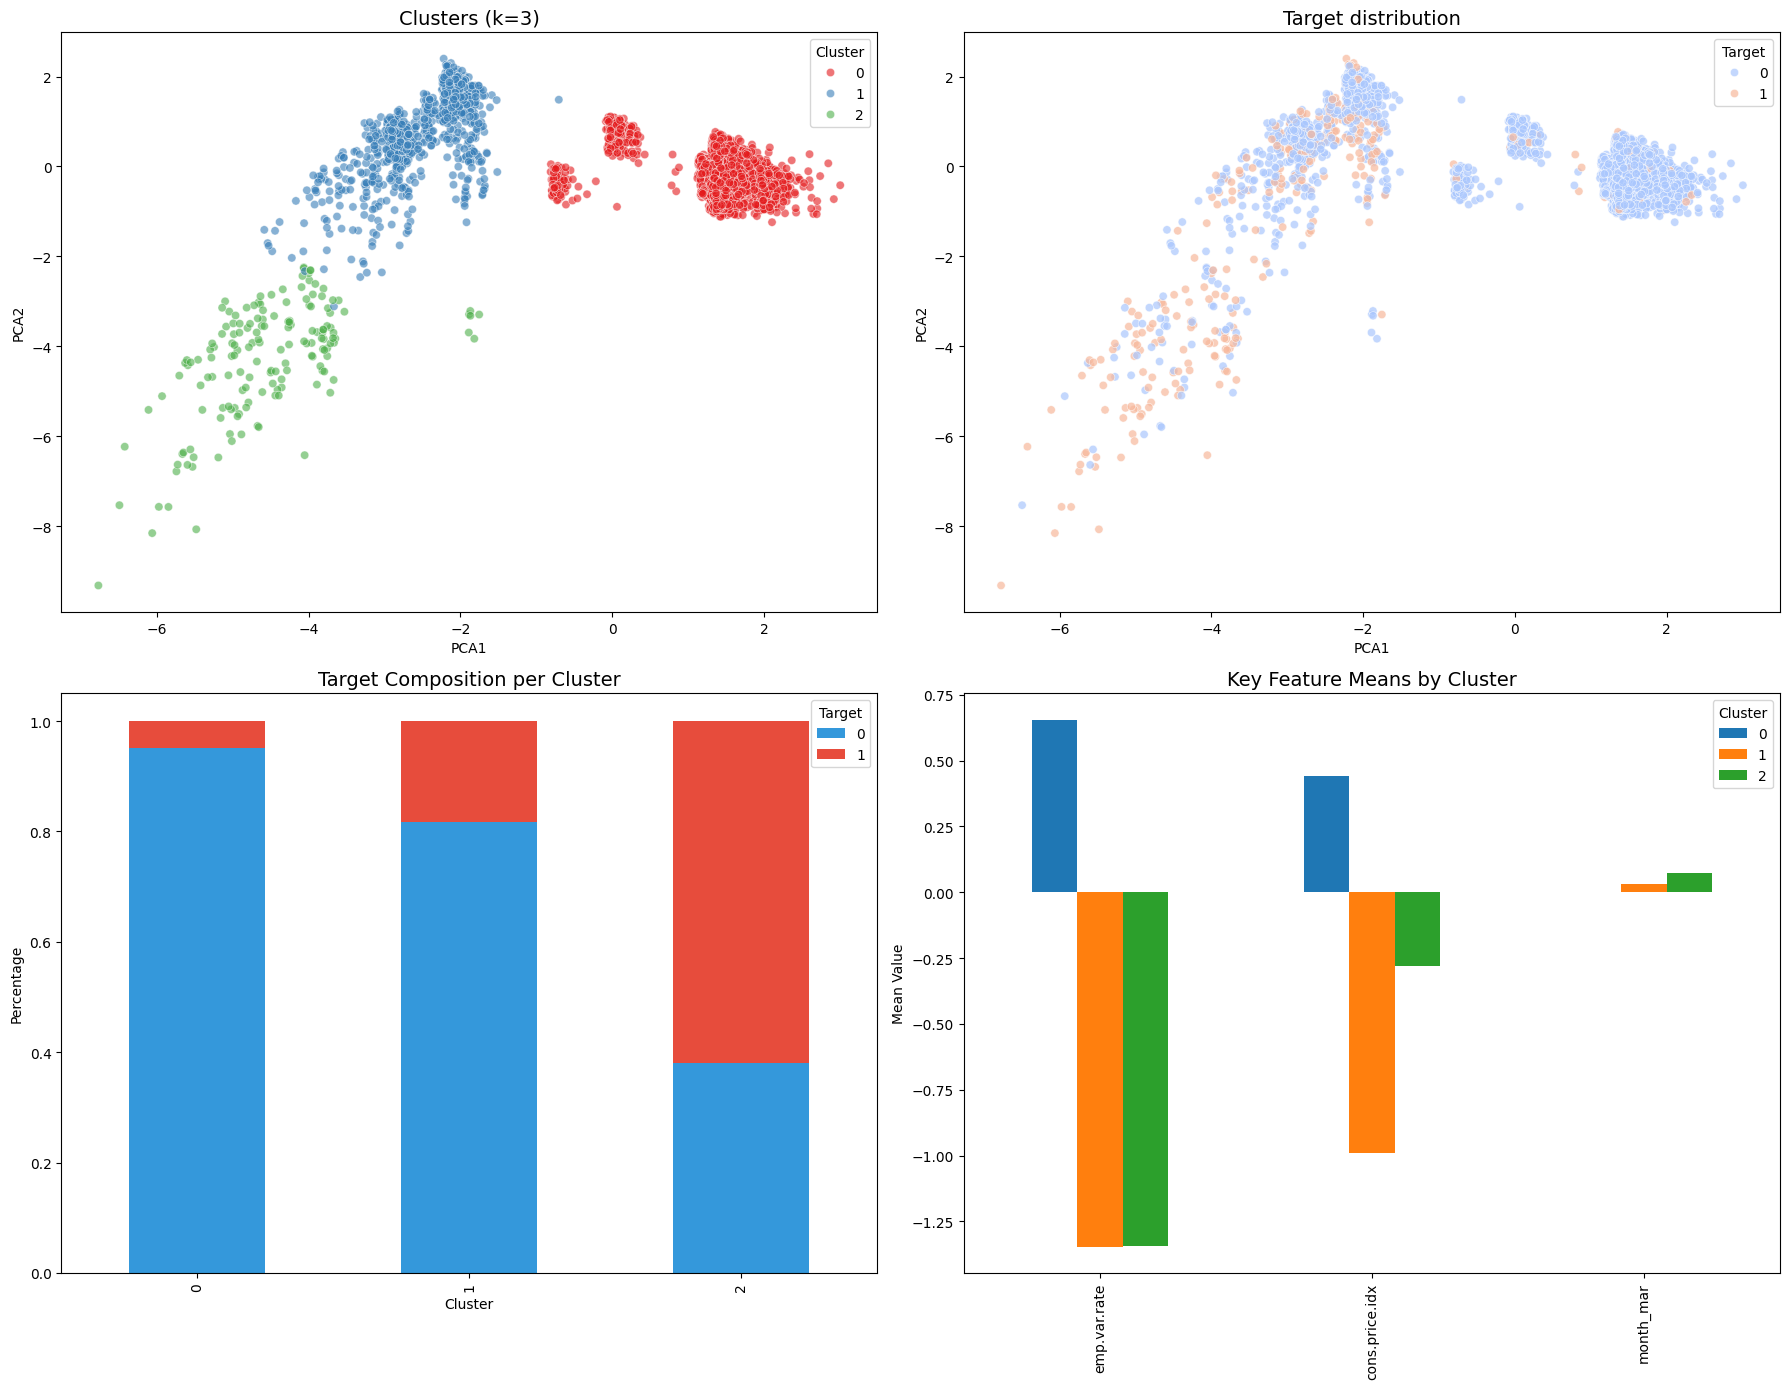

In [158]:
df_analysis = pd.DataFrame(X_prepared, columns=feature_names) # 如果没有特征名，可删此行
df_analysis['Cluster'] = clusters
df_analysis['Target'] = Y

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_prepared)
df_analysis['PCA1'] = pca_data[:, 0]
df_analysis['PCA2'] = pca_data[:, 1]

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

sns.scatterplot(data=df_analysis, x='PCA1', y='PCA2', hue='Cluster',
                palette='Set1', alpha=0.6, ax=axes[0, 0])
axes[0, 0].set_title(f'Clusters (k={k})', fontsize=14)

sns.scatterplot(data=df_analysis, x='PCA1', y='PCA2', hue='Target',
                palette='coolwarm', alpha=0.7, ax=axes[0, 1])
axes[0, 1].set_title('Target distribution', fontsize=14)

# LLM helps me to draw two success plots
target_counts = df_analysis.groupby(['Cluster', 'Target']).size().unstack(fill_value=0)
target_pct = target_counts.div(target_counts.sum(axis=1), axis=0)
target_pct.plot(kind='bar', stacked=True, ax=axes[1, 0], color=['#3498db', '#e74c3c'])
axes[1, 0].set_title('Target Composition per Cluster', fontsize=14)
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].legend(title='Target', loc='upper right')

key_features = ['emp.var.rate', 'cons.price.idx']
if 'month_mar' in df_analysis.columns:
    key_features.append('month_mar')

cluster_means = df_analysis.groupby('Cluster')[key_features].mean()
cluster_means.T.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Key Feature Means by Cluster', fontsize=14)
axes[1, 1].set_ylabel('Mean Value')

plt.tight_layout()
plt.show()

Thus, if the data has three clusters, the cluster 2 is our main target, since it shows around 60% "yes", which also shows on the PCA plots. Also, cluster 2 during periods of low economic volatility, includes effective communication for the month of March.

SHAP interperter:

In [162]:
preprocess = model_log.named_steps['preprocess']
log_reg = model_log.named_steps['clf']

X_train_scaled = preprocess.transform(X_train)
features = []

# LLM helped me to take out the parameters from preprocessor
for name, transformer, colunms in preprocess.transformers_:
    if name == 'category':
      ohe = transformer
      features.extend(ohe.get_feature_names_out(colunms))
    elif name == 'numerical':
      features.extend(colunms)

explainer = shap.LinearExplainer(
    log_reg,
    X_train_scaled,
    feature_names=features
)

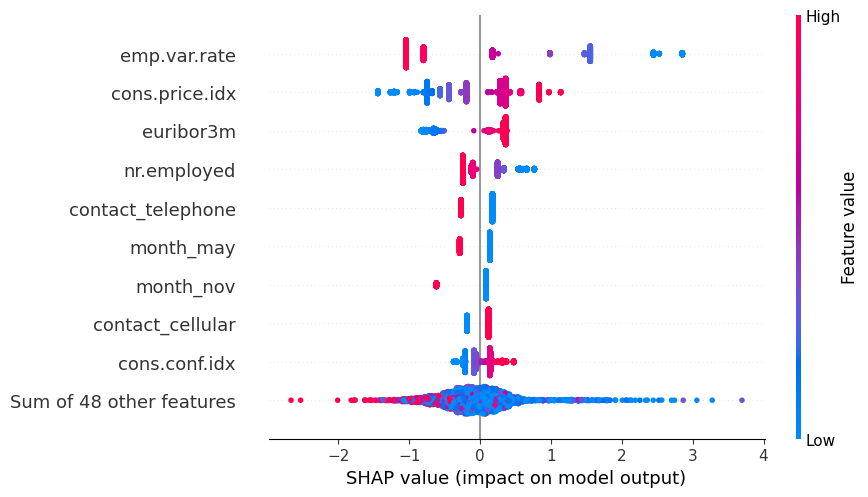

In [160]:
shap_values = explainer(X_train_scaled)

shap.plots.beeswarm(shap_values)

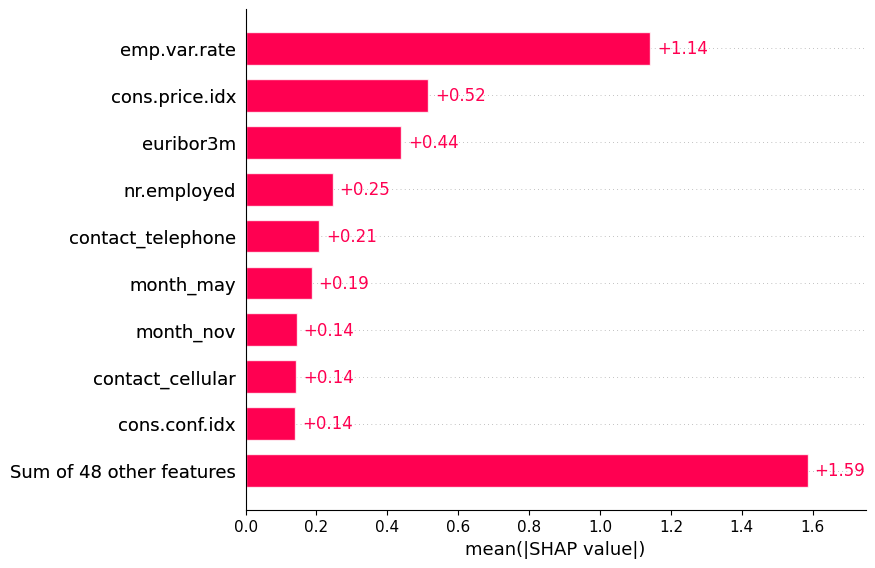

In [161]:
shap.plots.bar(shap_values)

After SHAP interpreter
>Summary plot: it shows `emp.var.rate`, `cons.price.idx` and `euribor3m` are top 3, for example, when `emp.var.rate` turns lower, it has positive influence to the model.

>Bar Plot: it shows the `emp.var.rate` is the main key, which means when categorize a customer to cluster A or B will depend on economic backround indicators, instead personal attributes

# Conclusions

***Dataset***:

> This data has many `"unkown"` values on the category list. But except `default`, they are around (0.26%) to (4.05%), thus maybe imput the most common value will be fine, and let `"unkown"` as new feature on the `default`.

> Since pdays only has 0 and 999, thus I changed 999 to 1, for building a better model.

> Outliers handling: I think outliers have a special meaning can explain the model, e.g: `campaign` associated with excessive markerting, which will lose the information.

LLM usage:

I used GPT and Gemini, I used them to help me fix my code and help me to find which metric is better. Also, it helped me to learn how to put those parameters into functions correctly. Sometimes, I have to change the results based on what I want, and let it to think about the results are good or not, ask it are there any ideas can optimize my results.

***Logistic regression***:

A significant shift in model behavior is observed through threshold optimization:

> The model correctly identified **52** True Positives but missed **103** False Negatives.

> By adjusting the decision threshold, the model achieved a perfectly balanced error rate, with **45** False Positives and **45** False Negatives. This optimization improved the model's ability to capture positive cases at the cost of some precision. Enhance the recall rate.

>***Conclusion***:

>>The model is highly sensitive to the macro-economic environment. Strategic focus should be placed on periods of low `emp.var.rate` and leveraging cellular communication to maximize the conversion rates identified in the performance metrics.

***K-Means***:

> I was surprised by while the initial exploration suggested `k=9`, the Elbow Method indicates that the most significant reduction in inertia occurs at `k=3`. Using `k=3` provides a robust balance between model complexity and interpretability, effectively separating the data into three distinct macro-environments without overfitting.

> From **PCA** plot, it shows cluster 2 has high conversion, and the target **"yes"** exceeds 60% of the composition.

> From SHAP, it shows `emp.var.rate` is the most influential feature and with high negative coefficient (-1.26), shows that lower economic volatility is strongly correlated with a target **"yes"**.

>***Conclusion:***

>>Cluster 2 is defined by a combination of a stable economic environment and the seasonal advantage of March. The comparison proves that your Target variable is heavily dependent on external economic context rather than just individual customer behavior.

**What I superised:**

While one might expect age or job to be the primary drivers, the SHAP and Coefficient analysis show that macro-economic indicators are the dominant forces. **It predicts success based on the state of the economy rather than just individual customer traits.**